<a href="https://colab.research.google.com/github/20WH1A6637/MarchMachineLearningMania2021/blob/main/MarchMachineLearningMania2021Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import log_loss
import lightgbm as lgb

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/MarchMachineLearningMania2021/ncaam-march-mania-2021 (1)/MDataFiles_Stage1'
STAGE_1 = True

In [ ]:
MRSCResults = pd.read_csv(data + '/MRegularSeasonCompactResults.csv')
MRSCResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
166875,2020,128,1204,81,1209,62,A,0
166876,2020,128,1402,85,1111,68,H,0
166877,2020,128,1299,86,1224,77,N,0
166878,2020,128,1393,81,1314,53,N,0


In [ ]:
A_w = MRSCResults[MRSCResults.WLoc == 'A']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_A"})
print(A_w.head())
N_w = MRSCResults[MRSCResults.WLoc == 'N']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_N"})
H_w = MRSCResults[MRSCResults.WLoc == 'H']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_H"})
win = A_w.join(N_w, how='outer').join(H_w, how='outer').fillna(0)

H_l = MRSCResults[MRSCResults.WLoc == 'A']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_H"})
N_l = MRSCResults[MRSCResults.WLoc == 'N']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_N"})
A_l = MRSCResults[MRSCResults.WLoc == 'H']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_A"})
lost = A_l.join(N_l, how='outer').join(H_l, how='outer').fillna(0)
print(win)
print(lost)
win.index = win.index.rename(['Season', 'TeamID'])
lost.index = lost.index.rename(['Season', 'TeamID'])
wl = win.join(lost, how='outer').reset_index()
print(wl)
wl['win_pct_A'] = wl['win_A'] / (wl['win_A'] + wl['lost_A'])
wl['win_pct_N'] = wl['win_N'] / (wl['win_N'] + wl['lost_N'])
wl['win_pct_H'] = wl['win_H'] / (wl['win_H'] + wl['lost_H'])
wl['win_pct_All'] = (wl['win_A'] + wl['win_N'] + wl['win_H']) / \
    (wl['win_A'] + wl['win_N'] + wl['win_H'] + wl['lost_A']\
     + wl['lost_N'] + wl['lost_H'])
print(wl)
del A_w, N_w, H_w, H_l, N_l, A_l, win, lost

                win_A
Season WTeamID       
1985   1102         3
       1103         2
       1104         5
       1106         1
       1108         8
                win_A  win_N  win_H
Season WTeamID                     
1985   1102       3.0    0.0    2.0
       1103       2.0    0.0    7.0
       1104       5.0    1.0   15.0
       1106       1.0    1.0    8.0
       1108       8.0    3.0    8.0
...               ...    ...    ...
2020   1463      11.0    2.0    8.0
       1464       5.0    0.0   11.0
       1465       6.0    0.0   11.0
       1466       4.0    0.0    7.0
       1467       9.0    1.0    9.0

[11580 rows x 3 columns]
                lost_A  lost_N  lost_H
Season LTeamID                        
1985   1102        9.0     2.0     8.0
       1103        8.0     0.0     6.0
       1104        6.0     2.0     1.0
       1106       10.0     3.0     1.0
       1108        4.0     1.0     1.0
...                ...     ...     ...
2020   1463        6.0     0.0     1.0
 

In [ ]:
MRSCResults['relScore'] = MRSCResults.WScore - MRSCResults.LScore

w_scr = MRSCResults.loc[:, ['Season', 'WTeamID', 'WScore', 'WLoc','relScore']]
w_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
#print(w_scr)
l_scr = MRSCResults.loc[:, ['Season', 'LTeamID', 'LScore', 'WLoc','relScore']]
#print(l_scr)
l_scr['WLoc'] = l_scr.WLoc.apply(lambda x: 'H' if x == 'A' else 'A' if x == 'H' else 'N')
l_scr['relScore'] = -1 * l_scr.relScore 
l_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
#print(l_scr)
wl_scr = pd.concat([w_scr,l_scr])
#print(wl_scr)
A_scr = wl_scr[wl_scr.Loc == 'A'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_A", "relScore": "relScore_A"})
#print(A_scr)
N_scr = wl_scr[wl_scr.Loc == 'N'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_N", "relScore": "relScore_N"})
H_scr = wl_scr[wl_scr.Loc == 'H'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_H", "relScore": "relScore_H"})
All_scr = wl_scr.groupby(['Season','TeamID'])['Score','relScore']\
    .mean().rename(columns={"Score": "Score_All", "relScore": "relScore_All"})
scr = A_scr.join(N_scr, how='outer').join(H_scr, how='outer')\
    .join(All_scr, how='outer').fillna(0).reset_index()
print(scr)
del w_scr, l_scr, wl_scr, A_scr, H_scr, N_scr, All_scr

       Season  TeamID    Score_A  relScore_A  Score_N  relScore_N    Score_H  \
0        1985    1102  62.833333   -8.166667    55.50  -12.500000  64.900000   
1        1985    1103  60.800000   -8.300000     0.00    0.000000  61.230769   
2        1985    1104  65.181818    4.000000    53.00   -0.333333  73.687500   
3        1985    1106  72.272727   -7.272727    64.50  -14.000000  74.000000   
4        1985    1108  78.583333    1.583333    77.75    5.250000  91.222222   
...       ...     ...        ...         ...      ...         ...        ...   
11589    2020    1463  72.058824    4.647059    77.00   21.000000  78.666667   
11590    2020    1464  69.125000   -6.875000     0.00    0.000000  73.400000   
11591    2020    1465  68.090909   -0.181818     0.00    0.000000  81.812500   
11592    2020    1466  69.294118   -7.235294     0.00    0.000000  64.636364   
11593    2020    1467  59.000000   -4.000000    50.00    0.500000  66.818182   

       relScore_H  Score_All  relScore_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
MRSDetailedResults = pd.read_csv(data + '/MRegularSeasonDetailedResults.csv')
MRSDetailedResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92827,2020,128,1389,56,1233,54,N,0,15,60,...,16,18,20,4,27,6,17,8,4,20
92828,2020,128,1393,81,1314,53,N,0,28,61,...,16,11,13,13,29,9,18,0,1,18
92829,2020,128,1402,85,1111,68,H,0,34,57,...,15,25,35,8,17,6,18,7,2,18
92830,2020,128,1412,74,1427,69,N,0,26,53,...,27,7,7,12,22,11,13,4,2,18


In [ ]:
w = MRSDetailedResults.loc[:, ['Season', 'WTeamID', 'WFGM','WFGA','WFGM3'
                               ,'WFGA3','WFTM','WFTA','WOR','WDR','WAst',
                               'WTO','WStl','WBlk','WPF']]
w.columns = ['Season', 'TeamID', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR',
             'Ast','TO','Stl','Blk','PF']
#print(w)
l = MRSDetailedResults.loc[:, ['Season', 'LTeamID', 'LFGM','LFGA','LFGM3',
                               'LFGA3','LFTM','LFTA','LOR','LDR','LAst',
                               'LTO','LStl','LBlk','LPF']]
l.columns = ['Season', 'TeamID', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR',
             'Ast','TO','Stl','Blk','PF']

detail = pd.concat([w,l])
#print(detail)
detail['goal_rate'] = detail.FGM / detail.FGA 
detail['3p_goal_rate'] = detail.FGM3 / detail.FGA3  
detail['ft_goal_rate'] = detail.FTM  / detail.FTA  

dt = detail.groupby(['Season','TeamID'])['FGM','FGA','FGM3','FGA3','FTM','FTA',
                                         'OR','DR','Ast','TO','Stl','Blk','PF',
                                          'goal_rate', '3p_goal_rate',
                                         'ft_goal_rate']\
                                        .mean().fillna(0).reset_index()
print(dt)

del w, l, detail

      Season  TeamID        FGM        FGA      FGM3       FGA3        FTM  \
0       2003    1102  19.142857  39.785714  7.821429  20.821429  11.142857   
1       2003    1103  27.148148  55.851852  5.444444  16.074074  19.037037   
2       2003    1104  24.035714  57.178571  6.357143  19.857143  14.857143   
3       2003    1105  24.384615  61.615385  7.576923  20.769231  15.423077   
4       2003    1106  23.428571  55.285714  6.107143  17.642857  10.642857   
...      ...     ...        ...        ...       ...        ...        ...   
6182    2020    1463  26.392857  57.285714  8.892857  24.071429  12.857143   
6183    2020    1464  25.580645  61.548387  7.193548  23.064516  12.838710   
6184    2020    1465  25.296296  58.925926  9.259259  24.555556  16.370370   
6185    2020    1466  22.892857  54.678571  6.642857  19.821429  15.035714   
6186    2020    1467  22.166667  53.533333  7.566667  22.700000   9.366667   

            FTA         OR         DR        Ast         TO    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
MMOrdinals = pd.read_csv(data + '/MMasseyOrdinals.csv')
MMOrdinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4120881,2020,128,WOL,1463,53
4120882,2020,128,WOL,1464,209
4120883,2020,128,WOL,1465,194
4120884,2020,128,WOL,1466,290


In [ ]:
MOR_127_128 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & ((MMOrdinals.RankingDayNum == 127) \
                | (MMOrdinals.RankingDayNum == 128))]\
                [['Season','TeamID','OrdinalRank']]
MOR_50_51 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 50) \
                 | (MMOrdinals.RankingDayNum == 51))]\
                [['Season','TeamID','OrdinalRank']]
MOR_15_16 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 15) \
                 | (MMOrdinals.RankingDayNum == 16))]\
                [['Season','TeamID','OrdinalRank']]

MOR_127_128 = MOR_127_128.rename(columns={'OrdinalRank':'OrdinalRank_127_128'})
#print(MOR_127_128)
MOR_50_51 = MOR_50_51.rename(columns={'OrdinalRank':'OrdinalRank_50_51'})
#print(MOR_50_51)
MOR_15_16 = MOR_15_16.rename(columns={'OrdinalRank':'OrdinalRank_15_16'})
#print(MOR_15_16)
MOR = MOR_127_128.merge(MOR_50_51, how='left', on=['Season','TeamID'])\
        .merge(MOR_15_16, how='left', on=['Season','TeamID'])
#print(MOR)
## normalizing Rank values by its season maxium as it varies by seasons
MOR_max = MOR.groupby('Season')['OrdinalRank_127_128','OrdinalRank_50_51',
                                'OrdinalRank_15_16'].max().reset_index()
MOR_max.columns = ['Season', 'maxRank_127_128', 'maxRank_50_51', 'maxRank_15_16']
#print(MOR_max)

MOR_tmp = MMOrdinals[(MMOrdinals.SystemName == 'MOR') \
                     & (MMOrdinals.RankingDayNum < 133)]
#print(MOR_tmp)
MOR_stats = MOR_tmp.groupby(['Season','TeamID'])['OrdinalRank']\
            .agg(['max','min','std','mean']).reset_index()

MOR_stats.columns = ['Season','TeamID','RankMax','RankMin','RankStd','RankMean']
#print(MOR_stats)
MOR = MOR.merge(MOR_max, how='left', on='Season')\
        .merge(MOR_stats, how='left', on=['Season','TeamID'])
#print(MOR)
MOR['OrdinalRank_127_128'] = MOR['OrdinalRank_127_128'] / MOR['maxRank_127_128']
MOR['OrdinalRank_50_51'] = MOR['OrdinalRank_50_51'] / MOR['maxRank_50_51']
MOR['OrdinalRank_15_16'] = MOR['OrdinalRank_15_16'] / MOR['maxRank_15_16']
MOR['RankTrans_50_51_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_50_51']
MOR['RankTrans_15_16_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_15_16']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [ ]:
wl_1 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in wl_1.columns ]
#print(wl_1)

wl_2 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in wl_2.columns ]
#print(wl_2)
scr_1 = scr.copy()
scr_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_1.columns ]
#print(scr_1)
scr_2 = scr.copy()
scr_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_2.columns ]
#print(scr_2)
dt_1 = dt.copy()
dt_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_1.columns ]

dt_2 = dt.copy()
dt_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_2.columns ]

MOR_1 = MOR.copy()
MOR_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_1.columns ]

MOR_2 = MOR.copy()
MOR_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_2.columns ]


In [ ]:
TCResults = pd.read_csv(data + '/MNCAATourneyCompactResults.csv')
TCResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0


In [ ]:
tourney1 = TCResults.loc[:, ['Season','WTeamID','LTeamID']]
tourney1.columns = ['Season','TeamID1','TeamID2']
tourney1['result'] = 1

tourney2 = TCResults.loc[:, ['Season','LTeamID','WTeamID']]
tourney2.columns = ['Season','TeamID1','TeamID2']
tourney2['result'] = 0
print(TCResults)
print(tourney1)
print(tourney2)
tourney = pd.concat([tourney1, tourney2])
print(tourney)
del tourney1, tourney2

      Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0       1985     136     1116      63     1234      54    N      0
1       1985     136     1120      59     1345      58    N      0
2       1985     136     1207      68     1250      43    N      0
3       1985     136     1229      58     1425      55    N      0
4       1985     136     1242      49     1325      38    N      0
...      ...     ...      ...     ...      ...     ...  ...    ...
2246    2019     146     1120      77     1246      71    N      1
2247    2019     146     1277      68     1181      67    N      0
2248    2019     152     1403      61     1277      51    N      0
2249    2019     152     1438      63     1120      62    N      0
2250    2019     154     1438      85     1403      77    N      1

[2251 rows x 8 columns]
      Season  TeamID1  TeamID2  result
0       1985     1116     1234       1
1       1985     1120     1345       1
2       1985     1207     1250       1
3       1985   

In [ ]:
def merge_data(df):

    df = df.merge(wl_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(wl_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)


    df = df.merge(scr_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(scr_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df = df.merge(dt_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(dt_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df = df.merge(MOR_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(MOR_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df['OrdinalRank_127_128_diff'] = df['OrdinalRank_127_128_1'] \
        - df['OrdinalRank_127_128_2']
    
    df['magic1'] = df['OrdinalRank_127_128_diff'] - df['RankMean_1']
    df['magic2'] = df['RankMean_1'] - df['RankMean_2']
    df['magic3'] = df['OrdinalRank_127_128_diff'] - df['RankMean_2']
    
    df['magic11'] = df['OrdinalRank_127_128_diff'] * df['RankMean_1']
    df['magic21'] = df['RankMean_1'] * df['RankMean_2']
    df['magic31'] = df['OrdinalRank_127_128_diff'] * df['RankMean_2']
    
    df['magic12'] = df['OrdinalRank_127_128_diff'] / df['RankMean_1']
    df['magic22'] = df['RankMean_1'] / df['RankMean_2']
    df['magic32'] = df['OrdinalRank_127_128_diff'] / df['RankMean_2']

    df = df.fillna(-1)

    for col in df.columns:
        if (df[col] == np.inf).any() or (df[col] == -np.inf).any():
            df[col][(df[col] == np.inf) | (df[col] == -np.inf)] = -1
    
    return df

tourney = merge_data(tourney)
tourney = tourney.loc[tourney.Season >= 2003,:].reset_index(drop=True)

if STAGE_1:
    tourney = tourney.loc[tourney.Season < 2015, :]

In [ ]:
if STAGE_1:
    MSampleSubmission = pd.read_csv(data + '/MSampleSubmissionStage1.csv')
else:
    MSampleSubmission = pd.read_csv(data + '/MSampleSubmissionStage2.csv') 

test1 = MSampleSubmission.copy()
test1['Season'] = test1.ID.apply(lambda x: int(x[0:4]))
test1['TeamID1'] = test1.ID.apply(lambda x: int(x[5:9]))
test1['TeamID2'] = test1.ID.apply(lambda x: int(x[10:14]))

test2 = MSampleSubmission.copy()
test2['Season'] = test2.ID.apply(lambda x: int(x[0:4]))
test2['TeamID1'] = test2.ID.apply(lambda x: int(x[10:14]))
test2['TeamID2'] = test2.ID.apply(lambda x: int(x[5:9]))

test = pd.concat([test1,test2]).drop(['Pred'], axis=1)
print(test)
test = merge_data(test)
print(test)

                   ID  Season  TeamID1  TeamID2
0      2015_1107_1112    2015     1107     1112
1      2015_1107_1116    2015     1107     1116
2      2015_1107_1124    2015     1107     1124
3      2015_1107_1125    2015     1107     1125
4      2015_1107_1129    2015     1107     1129
...               ...     ...      ...      ...
11385  2019_1449_1459    2019     1459     1449
11386  2019_1449_1463    2019     1463     1449
11387  2019_1458_1459    2019     1459     1458
11388  2019_1458_1463    2019     1463     1458
11389  2019_1459_1463    2019     1463     1459

[22780 rows x 4 columns]
                   ID  Season  TeamID1  TeamID2  win_pct_A_1  win_pct_N_1  \
0      2015_1107_1112    2015     1107     1112     0.705882         -1.0   
1      2015_1107_1116    2015     1107     1116     0.705882         -1.0   
2      2015_1107_1124    2015     1107     1124     0.705882         -1.0   
3      2015_1107_1125    2015     1107     1125     0.705882         -1.0   
4      2015_1

In [ ]:
tourney

,Season,TeamID1,TeamID2,result,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,OrdinalRank_127_128_diff,magic1,magic2,magic3,magic11,magic21,magic31,magic12,magic22,magic32
0,2003,1421,1411,1,0.125000,1.000000,0.833333,0.448276,0.333333,0.750000,...,-0.067278,-267.995850,-39.071429,-307.067278,-18.025775,82254.071429,-20.654434,-0.000251,0.872732,-0.000219
1,2003,1112,1436,1,0.916667,0.000000,0.933333,0.892857,0.500000,0.600000,...,-0.565749,-3.280035,-192.785714,-196.065749,-1.535605,530.642857,-110.603976,-0.208434,0.013884,-0.002894
2,2003,1113,1272,1,0.400000,0.500000,0.800000,0.620690,0.636364,1.000000,...,0.006116,-33.708170,-5.500000,-39.208170,0.206204,1322.081633,0.239843,0.000181,0.859745,0.000156
3,2003,1141,1166,1,0.642857,1.000000,0.916667,0.793103,0.636364,1.000000,...,0.100917,-125.184797,106.071429,-19.113368,12.643512,2407.275510,1.939056,0.000805,6.520446,0.005252
4,2003,1143,1301,1,0.636364,0.250000,0.928571,0.724138,0.300000,0.500000,...,-0.003058,-44.931630,14.214286,-30.717344,-0.137396,1379.948980,-0.093927,-0.000068,1.462791,-0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2014,1277,1163,0,0.700000,0.875000,0.750000,0.764706,0.636364,0.833333,...,-0.031339,-5.475783,-12.000000,-17.475783,-0.170624,94.975309,-0.546692,-0.005756,0.312102,-0.001797
1891,2014,1276,1246,0,0.636364,0.714286,0.866667,0.757576,0.500000,0.500000,...,-0.091168,-5.480057,-19.555556,-25.035613,-0.491295,134.422840,-2.274137,-0.016918,0.216036,-0.003655
1892,2014,1196,1163,0,0.833333,1.000000,1.000000,0.941176,0.636364,0.833333,...,-0.048433,-14.215100,-3.277778,-17.492877,-0.686135,247.129630,-0.844888,-0.003419,0.812102,-0.002776
1893,2014,1458,1246,0,0.727273,0.800000,0.823529,0.787879,0.500000,0.500000,...,-0.068376,-10.957265,-14.055556,-25.012821,-0.744539,271.617284,-1.705603,-0.006279,0.436526,-0.002741


In [ ]:
test

,ID,Season,TeamID1,TeamID2,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,OrdinalRank_127_128_diff,magic1,magic2,magic3,magic11,magic21,magic31,magic12,magic22,magic32
0,2015_1107_1112,2015,1107,1112,0.705882,-1.0,0.800000,0.750000,0.727273,1.000000,...,0.415954,-165.525222,161.647059,-3.878163,69.023965,712.570934,1.786157,0.002507,38.643836,0.096866
1,2015_1107_1116,2015,1107,1116,0.705882,-1.0,0.800000,0.750000,0.583333,0.666667,...,0.333333,-165.607843,136.588235,-29.019608,55.313725,4870.861592,9.784314,0.002009,5.653307,0.011356
2,2015_1107_1124,2015,1107,1124,0.705882,-1.0,0.800000,0.750000,0.545455,0.500000,...,0.367521,-165.573655,127.823529,-37.750126,60.986928,6325.287197,14.009050,0.002215,4.353395,0.009642
3,2015_1107_1125,2015,1107,1125,0.705882,-1.0,0.800000,0.750000,0.466667,1.000000,...,0.034188,-165.906988,17.588235,-148.318753,5.673203,24617.861592,5.071895,0.000206,1.118557,0.000230
4,2015_1107_1129,2015,1107,1129,0.705882,-1.0,0.800000,0.750000,0.615385,0.666667,...,0.313390,-165.627786,100.823529,-64.804257,52.004357,10805.698962,20.407240,0.001889,2.548329,0.004813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22775,2019_1449_1459,2019,1459,1449,0.785714,1.0,0.923077,0.866667,0.636364,0.571429,...,-0.073654,-33.740321,-11.833333,-45.573654,-2.479698,1531.833333,-3.351275,-0.002188,0.739927,-0.001619
22776,2019_1449_1463,2019,1463,1449,0.615385,1.0,0.846154,0.750000,0.636364,0.571429,...,0.138810,-95.583412,50.222222,-45.361190,13.287221,4355.361111,6.315864,0.001450,2.103785,0.003051
22777,2019_1458_1459,2019,1459,1458,0.785714,1.0,0.923077,0.866667,0.615385,0.600000,...,0.011331,-33.655335,13.166667,-20.488669,0.381492,690.166667,0.232295,0.000337,1.642276,0.000553
22778,2019_1458_1463,2019,1463,1458,0.615385,1.0,0.846154,0.750000,0.615385,0.600000,...,0.223796,-95.498426,75.222222,-20.276204,21.422254,1962.305556,4.587819,0.002338,4.669377,0.010917


In [ ]:
X = tourney.drop(['Season','TeamID1','TeamID2','result'], axis=1)
y = tourney["result"]
s = tourney["Season"]

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)
X_test

,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,win_pct_H_2,win_pct_All_2,Score_A_1,relScore_A_1,...,OrdinalRank_127_128_diff,magic1,magic2,magic3,magic11,magic21,magic31,magic12,magic22,magic32
0,0.705882,-1.0,0.800000,0.750000,0.727273,1.000000,1.000000,0.911765,63.000000,4.000000,...,0.415954,-165.525222,161.647059,-3.878163,69.023965,712.570934,1.786157,0.002507,38.643836,0.096866
1,0.705882,-1.0,0.800000,0.750000,0.583333,0.666667,0.894737,0.764706,63.000000,4.000000,...,0.333333,-165.607843,136.588235,-29.019608,55.313725,4870.861592,9.784314,0.002009,5.653307,0.011356
2,0.705882,-1.0,0.800000,0.750000,0.545455,0.500000,0.882353,0.718750,63.000000,4.000000,...,0.367521,-165.573655,127.823529,-37.750126,60.986928,6325.287197,14.009050,0.002215,4.353395,0.009642
3,0.705882,-1.0,0.800000,0.750000,0.466667,1.000000,0.846154,0.677419,63.000000,4.000000,...,0.034188,-165.906988,17.588235,-148.318753,5.673203,24617.861592,5.071895,0.000206,1.118557,0.000230
4,0.705882,-1.0,0.800000,0.750000,0.615385,0.666667,0.916667,0.741935,63.000000,4.000000,...,0.313390,-165.627786,100.823529,-64.804257,52.004357,10805.698962,20.407240,0.001889,2.548329,0.004813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22775,0.785714,1.0,0.923077,0.866667,0.636364,0.571429,0.937500,0.764706,76.642857,10.571429,...,-0.073654,-33.740321,-11.833333,-45.573654,-2.479698,1531.833333,-3.351275,-0.002188,0.739927,-0.001619
22776,0.615385,1.0,0.846154,0.750000,0.636364,0.571429,0.937500,0.764706,78.153846,2.769231,...,0.138810,-95.583412,50.222222,-45.361190,13.287221,4355.361111,6.315864,0.001450,2.103785,0.003051
22777,0.785714,1.0,0.923077,0.866667,0.615385,0.600000,0.800000,0.696970,76.642857,10.571429,...,0.011331,-33.655335,13.166667,-20.488669,0.381492,690.166667,0.232295,0.000337,1.642276,0.000553
22778,0.615385,1.0,0.846154,0.750000,0.615385,0.600000,0.800000,0.696970,78.153846,2.769231,...,0.223796,-95.498426,75.222222,-20.276204,21.422254,1962.305556,4.587819,0.002338,4.669377,0.010917


In [ ]:
s.head()

0    2003
1    2003
2    2003
3    2003
4    2003
Name: Season, dtype: int64

In [ ]:
s.value_counts()

2011    134
2012    134
2013    134
2014    134
2003    128
2004    128
2005    128
2006    128
2007    128
2008    128
2009    128
2010    128
Name: Season, dtype: int64

In [ ]:
len(X_test)

22780

In [ ]:
def model_training(X, y, cv, groups, params, metric, early_stopping=10, \
    plt_iter=True, X_test=[], cat_features=[]):

    feature_importance = pd.DataFrame()
    val_scores=[]
    train_evals=[]
    valid_evals=[]

    if len(X_test) > 0:
        test_pred = np.zeros(len(X_test))

    for idx, (train_index, val_index) in enumerate(cv.split(X, y, groups)):

        print("###### fold %d ######" % (idx+1))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping,
                  verbose=20
                  )
        val_scores.append(model.best_score_['valid_1'][metric])
        train_evals.append(model.evals_result_['training'][metric])
        valid_evals.append(model.evals_result_['valid_1'][metric])

        if len(X_test) > 0:
            test_pred = test_pred + model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = idx+1
        feature_importance = pd.concat([feature_importance, fold_importance]
                                       , axis=0)

    if plt_iter:
        
        fig, axs = plt.subplots(2, 2, figsize=(9,6))
        
        for i, ax in enumerate(axs.flatten()):
            ax.plot(train_evals[i], label='training')
            ax.plot(valid_evals[i], label='validation')
            ax.set(xlabel='interations', ylabel=f'{metric}')
            ax.set_title(f'fold {i+1}', fontsize=12)
            ax.legend(loc='upper right', prop={'size': 9})
        fig.tight_layout()
        plt.show()
    
    print('### CV scores by fold ###')
    for i in range(cv.get_n_splits(X)):
        print(f'fold {i+1}: {val_scores[i]:.4f}')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    feature_importance = feature_importance[["feature", "importance"]]\
                         .groupby("feature").mean().sort_values(
                         by="importance", ascending=False)
    feature_importance.reset_index(inplace=True)

    if len(X_test) > 0:
        test_pred = test_pred / cv.get_n_splits(X)
        return feature_importance, test_pred
    else:
        return feature_importance

In [ ]:
lgb_params = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 31,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'learning_rate': 0.1,
              'n_estimators': 1000,
}

In [ ]:
N_FOLDS = 10

###### fold 1 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0.339449	valid_1's binary_logloss: 0.585348
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.34892	valid_1's binary_logloss: 0.583679
###### fold 2 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0.341171	valid_1's binary_logloss: 0.593244
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.350999	valid_1's binary_logloss: 0.591129
###### fold 3 ######
Training until validation scores don't improve for 10 rounds.
[20]	training's binary_logloss: 0.339606	valid_1's binary_logloss: 0.579909
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.437734	valid_1's binary_logloss: 0.576397
###### fold 4 ######
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.516857	valid_1's binary_logloss: 0.65095

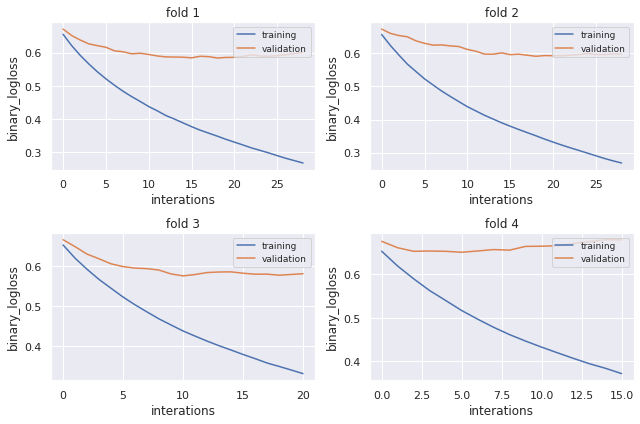

### CV scores by fold ###
fold 1: 0.5837
fold 2: 0.5911
fold 3: 0.5764
fold 4: 0.6510
fold 5: 0.5617
fold 6: 0.5258
fold 7: 0.4367
fold 8: 0.5170
fold 9: 0.5990
fold 10: 0.5484
CV mean score: 0.5591, std: 0.0547.
CPU times: user 8.52 s, sys: 191 ms, total: 8.71 s
Wall time: 5.18 s


In [ ]:
%%time
group_kfold = GroupKFold(n_splits=N_FOLDS)

feature_importance, test_pred = model_training(X, y, group_kfold, s, lgb_params, 'binary_logloss', plt_iter = True, X_test = X_test)

Text(0.5, 1.0, 'Feature Importnace')

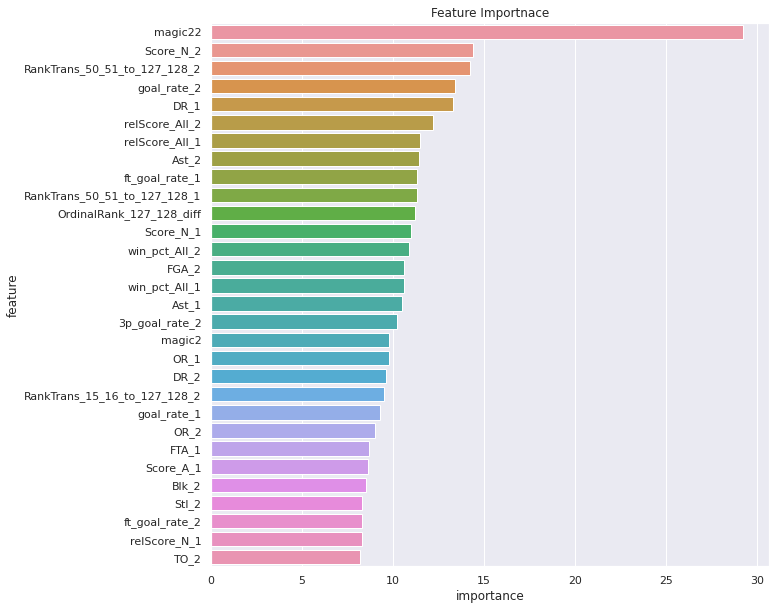

In [ ]:
plt.figure(figsize=(10, 10));
sns.barplot(x="importance", y="feature", data=feature_importance[:30])
plt.title('Feature Importnace')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm
import glob
import os
import gc
import xgboost as xgb

train = tourney
test = test

xgb_params= {
        "objective": "binary:logistic",
        "max_depth": 2,
        "learning_rate": 0.1,
        "colsample_bytree": 0.8,
        "subsample": 0.8,
        "min_child_weight": 30,
        "n_jobs": 2,
        "seed": 2021,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
        'predictor': 'gpu_predictor'
    }

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df_xgb = xgb.DMatrix(train_df, label=train_target)
        val_df_xgb = xgb.DMatrix(val_df, label=val_target)
        
        model = HistGradientBoostingClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        model1 = RandomForestClassifier()
        model2 = LogisticRegression(C=1)
        model3 = xgb.train(xgb_params, train_df_xgb, 1000)

        model =  model.fit(train_df, train_target)
        model1 =  model1.fit(train_df, train_target)
        model2 =  model2.fit(train_df, train_target)
        
        temp_oof = (model.predict_proba(val_df)[:,1] + model1.predict_proba(val_df)[:,1] + model2.predict_proba(val_df)[:,1] + model3.predict(val_df_xgb)) / 4

        temp_test = (model.predict_proba(X_test)[:,1] + model1.predict_proba(X_test)[:,1] + model2.predict_proba(X_test)[:,1] + model3.predict(xgb.DMatrix(X_test))) / 4

        train_oof[val_ind] = temp_oof

        test_preds += temp_test / NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))
        
print('CV', log_loss(y, train_oof))        
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

test = test
MSampleSubmission = pd.read_csv(data + '/MSampleSubmissionStage1.csv')

idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub3 = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
pred_3 = sub3['Pred']


0it [00:00, ?it/s]

XGBoostError: ignored

In [ ]:
0.5539459504635523

In [ ]:
idx = test_pred.shape[0] //2
test_pred[idx:] = 1 - test_pred[idx:]

pred = pd.concat([test.ID, pd.Series(test_pred)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub['Pred'] = sub['Pred'] * 0.3 + sub3['Pred'] * 0.7
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
if STAGE_1:
    rslt = pd.DataFrame()
    TCResults_s = TCResults.loc[TCResults.Season >= 2015,:]
    rslt['season'] = TCResults_s.Season
    rslt['team1'] = TCResults_s.apply(lambda x: x.WTeamID \
                                      if x.WTeamID < x.LTeamID else x.LTeamID
                                      , axis=1)
    rslt['team2'] = TCResults_s.apply(lambda x: x.WTeamID \
                                      if x.WTeamID > x.LTeamID else x.LTeamID
                                      , axis=1)
    rslt['wl'] = TCResults_s.apply(lambda x: 1 if x.WTeamID < x.LTeamID else 0
                                   , axis=1)
    rslt['ID'] = rslt.apply(lambda x: str(x.season) + '_' + str(x.team1) \
                            + '_' + str(x.team2), axis=1)
    sub2 = sub.merge(rslt.loc[:,['ID','wl']], how='inner', on='ID')

    preds = []
    for i in sub2.Pred:
        preds.append([1-i, i])

    print('Test logloss is {:.5f}'.format(log_loss(sub2.wl.values, preds)))

In [ ]:
0.51971

In [ ]:
!pip install gradio

In [ ]:
sub

In [ ]:
import gradio as gr

In [ ]:
def prediction_result(season, teamID_1, teamID_2):
    id = f"{int(season)}_{int(teamID_1)}_{int(teamID_2)}"
    pred = sub["Pred"].loc[sub["ID"] == id]
    p = pred.values
    return f"The winning probability of teamID {int(teamID_1)} is {round(p[0] * 100, 2)}%"

demo = gr.Interface(
    fn = prediction_result,
    inputs = ["number","number", "number"],
    outputs = "text", 
    title = "MENS MARCH MANIA 2021",
    description = """Predicted the outcome of the 2021 tournament""",
    examples = [[2015, 1107, 1112], [2015, 1107, 1129], [2019, 1459, 1463], [2015, 1107, 1125], [2019, 1458, 1459]],
    live = True
)

demo.launch(share = True)